# IRRIGATION ADVICE 

In [194]:
import import_ipynb
import datetime
import pandas
import json
import requests
from numpy import nan
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import dates as mdate
from sklearn.linear_model import LinearRegression
from IPython.display import Image
pandas.options.display.float_format = '{:,.3f}'.format
from BabiloniaDataAnalyticsOffline import BabiloniaDataAnalyticsOffline

#WEATHER_KEY secret
WEATHER_KEY = None
CFG = None
with open('../../server/app/config.json') as json_data_file:
    data = json.load(json_data_file)
    WEATHER_KEY = data["WEATHER_KEY"]
    CFG = data

In [332]:
# CONSTANTS

MOISTURE_PROBES = ['MUX0','MUX1','MUX2','MUX3','MUX4','MUX5','MUX6','MUX7']
ROLLING_WINDOW = 30 # RUPTURE_LEVEL_THRESHOLD and PCT_CHANGE_PERIOD are affected by this value
RUPTURE_LEVEL_THRESHOLD = 0.015
PCT_CHANGE_PERIOD = 10 # RUPTURE_LEVEL_THRESHOLD is affected by this value
HEARTBEAT_PERIOD=30 # (seconds) OMG 2 heartbeats
MOISTURE_DATA_PERIOD = 3*3600 # (seconds)
FORECAST_TIME_AHEAD = MOISTURE_DATA_PERIOD

PRECIPITATION_PROBABILITY_THRESHOLD=0.25
LN_SCORE_THRESHOLD=0.3
LATEST_LEVEL_CHECK_WINDOW=30
LATEST_LEVEL_CHECK_QUANTILE=0.3

# FUNCTIONS

def plot(series): 
    plt.rcParams['figure.figsize'] = [15,7]
    plt.rcParams['timezone'] = 'America/Sao_Paulo'

    fig,ax = plt.subplots()
    x = mdate.epoch2num(series.index)
    fmt = mdate.DateFormatter('%y-%m-%d %H:%M')

    ax.xaxis.set_major_formatter(fmt)
    plt.xticks( rotation=25 )
    plt.plot_date(x, series, linestyle='solid', marker='None')
    plt.legend(MOISTURE_PROBES)
    plt.show()
    
def filter_noise_in_moisture_data_cache(data):
    return data.rolling(ROLLING_WINDOW).mean().dropna()
    
def detect_rupture_oasis(data):
    #Percentage change between the current and a prior element
    # Finding negative or positive slopes ...
    # percent change over given number of period.
    pct_change_series = data.pct_change(periods=PCT_CHANGE_PERIOD).dropna()
    ### Gathering data
    ruptures={}
    min_probes={}
    max_probes={}
    for mux in MOISTURE_PROBES:
        min_entry={}
        min_entry['epoch'] = pct_change_series[mux].idxmin()
        min_entry['value'] = pct_change_series[mux][min_entry['epoch']]
        if min_entry['value'] < -RUPTURE_LEVEL_THRESHOLD:
            min_probes[mux] = min_entry

        max_entry={}
        max_entry['epoch'] = pct_change_series[mux].idxmax()
        max_entry['value'] = pct_change_series[mux][max_entry['epoch']]
        if max_entry['value'] > RUPTURE_LEVEL_THRESHOLD:
            max_probes[mux] = max_entry
    ruptures['downward'] = pandas.DataFrame(data=min_probes).T
    ruptures['upward'] =  pandas.DataFrame(data=max_probes).T
    return ruptures

def get_latest_moisture_level(data):
    return data.tail(LATEST_LEVEL_CHECK_WINDOW).quantile(LATEST_LEVEL_CHECK_QUANTILE).round(0).astype(int)

def linear_regressor(data):
    X = data.index.to_numpy().reshape(-1, 1)
    entries={}
    for mux in MOISTURE_PROBES:
        Y = data[mux].values.reshape(-1, 1)
        linear_regressor = LinearRegression()  # create object for the class
        linear_regressor.fit(X, Y)  # perform linear regression
        Y_pred = linear_regressor.predict(X)  # make predictions
        entry={}
        entry['score']=linear_regressor.score(X,Y)
        entry['coef'] =linear_regressor.coef_[0][0]
        entries[mux] = entry
    result = pandas.DataFrame(data=entries).T # transpose
    return result

def will_rain(now, display):
    will_rain = False
    lat = -22.019989
    long = -47.312531
    hourly_forecast={}
    try:
        response = requests.get(
        'https://api.forecast.io/forecast/%s/%s,%s,%s?units=si&lang=pt&exclude=currently,flags,alerts,daily'
        %(WEATHER_KEY, lat, long,now))
        data = response.json()
        hourly_forecast = pandas.DataFrame(data=data["hourly"]["data"])
        hourly_forecast.set_index('time', inplace=True)
        hourly_forecast_filtered = hourly_forecast[(hourly_forecast.index >= now ) & (hourly_forecast.index < now + FORECAST_TIME_AHEAD)]
        will_rain = len(hourly_forecast_filtered[
                        (hourly_forecast_filtered['precipProbability'] >= PRECIPITATION_PROBABILITY_THRESHOLD) |
                        (hourly_forecast_filtered['icon'] == 'rain')]) > 0
    except requests.ConnectionError:
        self.logger.debug("[will_rain] ConnectionError!!!")
    if display:
        return hourly_forecast_filtered
    return will_rain


def moisture_level_valid_value(value):
    nosoil = int(CFG['MUX_PORT_THRESHOLD']['NOSOIL'])
    offline = int(CFG['MUX_PORT_THRESHOLD']['OFFLINE'])
    if len(value) == 0:
        return False
    else:
        iv = int(value)
        if (iv < offline) | (iv > nosoil):
            return False
    return True


def moisture_level(node_training):
    probes_moisture_level={}
    dry = node_training.loc[node_training['VALUE'] == 'soil_dry']
    wet = node_training.loc[node_training['VALUE'] == 'soil_wet']
    default = int(CFG['MUX_PORT_THRESHOLD']['WET'])

    for probe in valid_probes:
        if not moisture_level_valid_value(dry[probe]):
            if not moisture_level_valid_value(wet[probe]):
                # SCENARIO A: No training feedback. Use defaults
                probes_moisture_level[probe] = default
            else: 
                wp = int(wet[probe])
                #  There is ONLY wet threshold feedback
                if wp > default:
                    # SCENARIO F: Change wet threshold due the feedback
                    probes_moisture_level[probe] = wp
                else:
                    # SCENARIO E: Do not change wet threshold. Default level might be ok
                    probes_moisture_level[probe] = default
        else:
            if not moisture_level_valid_value(wet[probe]):
                #  There is ONLY dry threshold feedback
                dp = int(dry[probe])
                if dp < default:
                    # SCENARIO G: Change wet threshold due the feedback
                    probes_moisture_level[probe] = dp
                else:
                    # SCENARIO D: Do not change wet threshold. Default level might be ok
                    probes_moisture_level[probe] = default
            else:
                # There are dry and wet feedbacks
                wp = int(wet[probe])
                dp = int(dry[probe])
                if wp < default:
                    if dp > default:
                        # SCENARIO A: Lets keep current default threshold
                        probes_moisture_level[probe] = default
                    else:
                        if wp > dp:
                            # Strange scenario
                            probes_moisture_level[probe] = default
                        else:
                        # SCENARIO C: Dry and Wet feedbacks are LOWER than current threshold
                            probes_moisture_level[probe] = (dp + wb)/2
                else:
                    # SCENARIO B: Dry and Wet feedbacks are HIGHER than current threshold
                    probes_moisture_level[probe] = (dp + wb)/2

    return pandas.Series(probes_moisture_level)

In [333]:
bda = BabiloniaDataAnalyticsOffline("./moisture_data_1604935353_1609325379.pkl")
bda.plot_node_moisture()

In [228]:
#TEST DATA
moisture_data = bda.NODE_MOISTURE_DATA[(bda.NODE_MOISTURE_DATA.index >= bda.START_TIME) & (bda.NODE_MOISTURE_DATA.index <= bda.NOW)]
#plot(moisture_data)

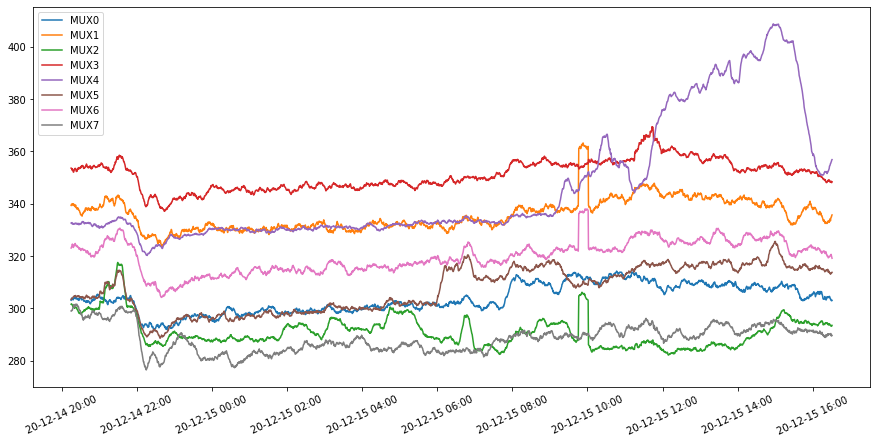

In [229]:
data_noise_filtered = filter_noise_in_moisture_data_cache(moisture_data)
plot(data_noise_filtered)

In [230]:
#plot(data_noise_filtered.pct_change(periods=PCT_CHANGE_PERIOD).dropna())

In [231]:
will_rain(bda.NOW, False)

True

In [232]:
#Ignoring malfuncional probes
latest_moisture_level = get_latest_moisture_level(data_noise_filtered)
valid_probes = latest_moisture_level[(latest_moisture_level > CFG['MUX_PORT_THRESHOLD']['OFFLINE']) & (latest_moisture_level < CFG['MUX_PORT_THRESHOLD']['NOSOIL'])].index.values
print(valid_probes)

['MUX0' 'MUX1' 'MUX2' 'MUX3' 'MUX4' 'MUX5' 'MUX6' 'MUX7']


In [233]:
latest_moisture_level = latest_moisture_level.loc[latest_moisture_level.index.intersection(valid_probes)]

**coef**: 0.001 means each 1000 secs, moisture level increases 1 point.
**score**: 1.0 is the best score

In [246]:
pandas.options.display.float_format = '{:,.3f}'.format

alpha = linear_regressor(data_noise_filtered)

In [235]:
ruptures = detect_rupture_oasis(data_noise_filtered)
ruptures['downward'].loc[ruptures['downward'].index.intersection(valid_probes)]

,epoch,value
MUX0,"1,607,994,316.000",-0.015
MUX1,"1,608,037,564.000",-0.069
MUX2,"1,608,037,534.000",-0.063
MUX3,"1,607,994,376.000",-0.016
MUX4,"1,608,058,054.000",-0.023
MUX5,"1,607,992,936.000",-0.021
MUX6,"1,608,037,384.000",-0.045
MUX7,"1,607,994,376.000",-0.030


In [236]:
ruptures['upward'].loc[ruptures['upward'].index.intersection(valid_probes)]

,epoch,value
MUX1,"1,608,036,454.000",0.071
MUX2,"1,608,036,454.000",0.063
MUX4,"1,608,052,024.000",0.024
MUX5,"1,608,023,507.000",0.019
MUX6,"1,608,036,664.000",0.046
MUX7,"1,607,995,276.000",0.016


In [237]:
#some fake data
training_feedback=[
        ['dummy', 'soil_dry', 500, 510, 345, 530, 540, 550, 560, 570],
        ['dummy', 'soil_wet', 300, 500, 340, 350, 460, 370, 380, 390],
    ]
# default configuration
CFG['MUX_PORT_THRESHOLD']

{'OFFLINE': 50, 'WET': 350, 'NOSOIL': 680}

In [238]:
training_feedback.extend ([
        ['oasis-39732c', 'soil_wet', 305, 341, 293, 340, 428, 350, 320, 285],
    ])

training = pandas.DataFrame(training_feedback, columns = 
        ['NODE_ID', 'VALUE', 'MUX0', 'MUX1', 'MUX2', 'MUX3', 'MUX4', 'MUX5', 'MUX6', 'MUX7'])

training

,NODE_ID,VALUE,MUX0,MUX1,MUX2,MUX3,MUX4,MUX5,MUX6,MUX7
0,dummy,soil_dry,500,510,345,530,540,550,560,570
1,dummy,soil_wet,300,500,340,350,460,370,380,390
2,oasis-39732c,soil_wet,305,341,293,340,428,350,320,285


![title](./img/threshold.png)


In [243]:
#node = 'nao_existe'
#node = 'dummy'
node = 'oasis-39732c'
node_training = training.loc[training['NODE_ID'] == node]
moisture_threshold_level = moisture_level(node_training)

In [352]:
def forecast_moisture_level(will_rain, alpha, latest_moisture_level, moisture_threshold_level):
    forecast = {}
    need_water_probes = 0
    entries={}

    total_probes = len(latest_moisture_level)
    for index, value in latest_moisture_level.items():
        entry={}
        threshold = moisture_threshold_level.get(index)
        coef = alpha.coef.get(index)
        score = alpha.score.get(index)
        future_value = value
        if score >= LN_SCORE_THRESHOLD:
            future_value += (coef*FORECAST_TIME_AHEAD).round(0).astype(int)
        if future_value >= threshold:
            need_water_probes+=1

        entry['actual_value'] = str(value)
        entry['threshold'] = str(threshold)
        entry['coef'] = str(float("{:.3f}".format(coef)))
        entry['score'] = str(float("{:.3f}".format(score)))
        entry['future_value'] = str(future_value)
        entries[index] = entry
    
    result =  float("{:.3f}".format(need_water_probes/total_probes))
    forecast['result'] = str(result)
    if result > 0.5:
        if will_rain:
            forecast['advice'] = 'POSPONE'
        else:
            forecast['advice'] = 'IRRIGATE'
    else:
        forecast['advice'] = 'NOTHING' 
    forecast['details'] = entries

    return json.dumps(forecast)

forecast_moisture_level(will_rain, alpha, latest_moisture_level, moisture_threshold_level)

'{"result": "0.125", "advice": "NOTHING", "details": {"MUX0": {"actual_value": "304", "threshold": "350", "coef": "0.0", "score": "0.536", "future_value": "306"}, "MUX1": {"actual_value": "333", "threshold": "350", "coef": "0.0", "score": "0.299", "future_value": "333"}, "MUX2": {"actual_value": "294", "threshold": "350", "coef": "-0.0", "score": "0.106", "future_value": "294"}, "MUX3": {"actual_value": "349", "threshold": "350", "coef": "0.0", "score": "0.362", "future_value": "351"}, "MUX4": {"actual_value": "352", "threshold": "428", "coef": "0.001", "score": "0.653", "future_value": "362"}, "MUX5": {"actual_value": "314", "threshold": "350", "coef": "0.0", "score": "0.659", "future_value": "318"}, "MUX6": {"actual_value": "320", "threshold": "350", "coef": "0.0", "score": "0.377", "future_value": "322"}, "MUX7": {"actual_value": "290", "threshold": "350", "coef": "0.0", "score": "0.078", "future_value": "290"}}}'

In [315]:
len(latest_moisture_level)

8

In [316]:
need_water_probes=0

In [317]:
need_water_probes+=1

In [318]:
need_water_probes

1